## Unit 3 Capstone -- Predicting whether or not a movie is "good"

I've been a movie fanatic since I was a kid and have quite a wealth of movie trivia knowledge.  My mentor (Artem Yankov) pointed me to this dataset on Kaggle as a suggestion for this capstone.  For this project, I will be predicting whether or not a movie is "good" based on its IMDb score.  Generally a movie with an IMDb rating of 7.0 or higher is considered good.  This dataset covers over 5000 movies from across the globe, with over 100 years worth of movie data.

In [94]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from pprint import pprint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=RuntimeWarning)
#warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [95]:
pd.set_option('display.max_columns', 99) #allows us to see all the columns

In [ ]:
<font color=blue>
Ok, let's load this puppy in and take a look!

In [96]:
df = pd.read_csv("c:/Thinkful/movie_metadata.csv")
print('Rows = {}, columns = {}\n'.format(df.shape[0],df.shape[1]))
df.head(2)

Rows = 5043, columns = 28



,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0


<font color=blue>
Looks like we have over 5000 movies in the data set and 28 variables.  Before we get started, a peak at the file showed that we have some duplicates and some missing data, so let's remove those first.

In [97]:
df = df.drop_duplicates().dropna()   
df.shape

(3723, 28)

<font color=blue>
So unfortunately we lost a bit of the data, but still have nearly over 3,700 movies to work with.  Ok, let's do a little exploration of the data set, starting with the IMDb scores so we know what we're dealing with.  I'll first create my predictor variable and 

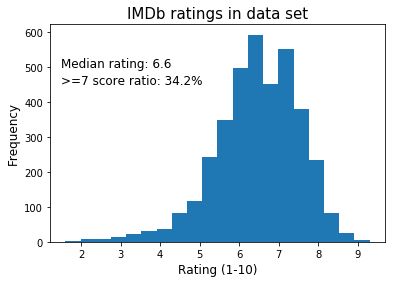

In [98]:
df['success'] = np.where(df['imdb_score']>=7,1,0)

x = round(df['success'].mean(),3)
plt.hist(df['imdb_score'], bins=20)
plt.xlabel("Rating (1-10)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("IMDb ratings in data set",fontsize=15)
plt.text(1.5,500,'Median rating: '+str(df['imdb_score'].median()),fontsize=12)
plt.text(1.5,450,'>=7 score ratio: '+str(100*x)+'%',fontsize=12)
plt.savefig("c:/thinkful/imdb_hist.png") # save as file for use in deck
plt.show()

<font color = blue>
So we can see that <font color=red>34.2%<font color = blue> of the movies are deemed "good" (by my definition of a score >= 7.0).  Our prediction has to be better than a 64.7% guess (which is what we will get if the model just predicts all 0's).<br>
    
Let's look at some other aspects of the data

In [99]:
df.country.value_counts()

USA               2961
UK                 313
France             101
Germany             79
Canada              59
Australia           39
Spain               21
Japan               15
Hong Kong           13
China               12
New Zealand         11
Italy               11
South Korea          8
Denmark              8
Ireland              7
Mexico               6
Brazil               5
India                5
Norway               4
Iran                 4
Thailand             4
South Africa         3
Czech Republic       3
Netherlands          3
Russia               3
Argentina            3
Hungary              2
Taiwan               2
Romania              2
Finland              1
Aruba                1
Georgia              1
Greece               1
Chile                1
Poland               1
New Line             1
Colombia             1
Indonesia            1
Iceland              1
Official site        1
West Germany         1
Afghanistan          1
Israel               1
Peru       

Text(0, 0.5, 'Gross')

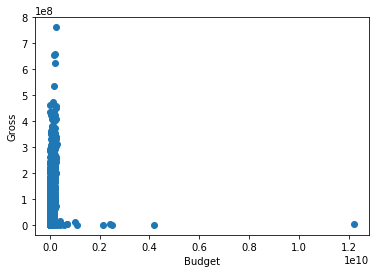

In [100]:
plt.scatter(df['budget'],df['gross'])
plt.xlabel('Budget')
plt.ylabel('Gross')

<font color=blue>
That doesn't look right.  I'm not aware of any movie that had a $12 billion budget.  Let's investigate. . .

In [101]:
df.sort_values(by=['budget'],ascending=False).head(15)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,success
2988,Color,Joon-ho Bong,363.0,110.0,584.0,74.0,Kang-ho Song,629.0,2201412.0,Comedy|Drama|Horror|Sci-Fi,Doona Bae,The Host,68883,1173,Ah-sung Ko,0.0,daughter|han river|monster|river|seoul,http://www.imdb.com/title/tt0468492/?ref_=fn_t...,279.0,Korean,South Korea,R,1.221550e+10,2006.0,398.0,7.0,1.85,7000,1
3859,Color,Chan-wook Park,202.0,112.0,0.0,38.0,Yeong-ae Lee,717.0,211667.0,Crime|Drama,Min-sik Choi,Lady Vengeance,53508,907,Hye-jeong Kang,0.0,cake|christian|lesbian sex|oral sex|pregnant s...,http://www.imdb.com/title/tt0451094/?ref_=fn_t...,131.0,Korean,South Korea,R,4.200000e+09,2005.0,126.0,7.7,2.35,4000,1
3005,Color,Lajos Koltai,73.0,134.0,45.0,0.0,Péter Fancsikai,9.0,195888.0,Drama|Romance|War,Marcell Nagy,Fateless,5603,11,Bálint Péntek,0.0,bus|death|gay slur|hatred|jewish,http://www.imdb.com/title/tt0367082/?ref_=fn_t...,45.0,Hungarian,Hungary,R,2.500000e+09,2005.0,2.0,7.1,2.35,607,1
2323,Color,Hayao Miyazaki,174.0,134.0,6000.0,745.0,Jada Pinkett Smith,893.0,2298191.0,Adventure|Animation|Fantasy,Minnie Driver,Princess Mononoke,221552,2710,Billy Crudup,0.0,anime|cult film|forest|princess|studio ghibli,http://www.imdb.com/title/tt0119698/?ref_=fn_t...,570.0,Japanese,Japan,PG-13,2.400000e+09,1997.0,851.0,8.4,1.85,11000,1
2334,Color,Katsuhiro Ôtomo,105.0,103.0,78.0,101.0,Robin Atkin Downes,488.0,410388.0,Action|Adventure|Animation|Family|Sci-Fi|Thriller,William Hootkins,Steamboy,13727,991,Rosalind Ayres,1.0,19th century|ball|boy|inventor|steam,http://www.imdb.com/title/tt0348121/?ref_=fn_t...,79.0,Japanese,Japan,PG-13,2.127520e+09,2004.0,336.0,6.9,1.85,973,0
3423,Color,Katsuhiro Ôtomo,150.0,124.0,78.0,4.0,Takeshi Kusao,6.0,439162.0,Action|Animation|Sci-Fi,Mitsuo Iwata,Akira,106160,28,Tesshô Genda,0.0,based on manga|biker gang|gifted child|post th...,http://www.imdb.com/title/tt0094625/?ref_=fn_t...,430.0,Japanese,Japan,R,1.100000e+09,1988.0,5.0,8.1,1.85,0,1
4542,Color,Takao Okawara,107.0,99.0,2.0,3.0,Naomi Nishida,43.0,10037390.0,Action|Adventure|Drama|Sci-Fi|Thriller,Hiroshi Abe,Godzilla 2000,5442,53,Sakae Kimura,0.0,godzilla|kaiju|monster|orga|ufo,http://www.imdb.com/title/tt0188640/?ref_=fn_t...,140.0,Japanese,Japan,PG,1.000000e+09,1999.0,3.0,6.0,2.35,339,0
3075,Color,Karan Johar,20.0,193.0,160.0,860.0,John Abraham,8000.0,3275443.0,Drama,Shah Rukh Khan,Kabhi Alvida Naa Kehna,13998,10822,Preity Zinta,2.0,extramarital affair|fashion magazine editor|ma...,http://www.imdb.com/title/tt0449999/?ref_=fn_t...,264.0,Hindi,India,R,7.000000e+08,2006.0,1000.0,6.0,2.35,659,0
3851,Color,Carlos Saura,35.0,115.0,98.0,4.0,Juan Luis Galiardo,341.0,1687311.0,Drama|Musical,Mía Maestro,Tango,2412,371,Miguel Ángel Solá,3.0,dancer|director|love|musical filmmaking|tango,http://www.imdb.com/title/tt0120274/?ref_=fn_t...,40.0,Spanish,Spain,PG-13,7.000000e+08,1998.0,26.0,7.2,2.00,539,1
1338,Color,John Woo,160.0,150.0,610.0,478.0,Tony Chiu Wai Leung,755.0,626809.0,Action|Adventure|Drama|History|War,Takeshi Kaneshiro,Red Cliff,36894,2172,Wei Zhao,4.0,alliance|battle|china|chinese|strategy,http://www.imdb.com/title/tt0425637/?ref_=fn_t...,105.0,Mandarin,China,R,5.536320e+08,2008.0,643.0,7.4,2.35,0,1


<font color = blue>
That explains it.  It appears that budget numbers are in local currency (for at least some countries), so they are artificially inflated, and some Asian countries look like the biggest offenders.  I'm going to remove some to bring some balance to the dataset.

In [102]:
x = (df['country'] != 'South Korea') & (df['country'] != 'Japan') & (df['country'] != 'Thailand')
df = df[x]

In [103]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

<font color=blue>
It looks like we have a lot of text cells, and most of them will add little to no value, so let's remove those.  I also don't think aspect ratio adds anything to a rating, so I'll remove that while I'm at it.

In [104]:
df = df.drop(['color','director_name','actor_1_name','actor_2_name','actor_3_name','movie_title',
              'plot_keywords','movie_imdb_link','aspect_ratio'],1)
df.head(1)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,success
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,886204,4834,0.0,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000,1


<font color=blue>
That's a little more manageable.  Let's take a look at the countries represented

In [105]:
df.country.value_counts()

USA               2961
UK                 313
France             101
Germany             79
Canada              59
Australia           39
Spain               21
Hong Kong           13
China               12
New Zealand         11
Italy               11
Denmark              8
Ireland              7
Mexico               6
Brazil               5
India                5
Norway               4
Iran                 4
Czech Republic       3
Netherlands          3
Argentina            3
South Africa         3
Russia               3
Hungary              2
Taiwan               2
Romania              2
Iceland              1
Georgia              1
New Line             1
Aruba                1
Indonesia            1
Finland              1
West Germany         1
Afghanistan          1
Israel               1
Colombia             1
Official site        1
Belgium              1
Poland               1
Chile                1
Greece               1
Peru                 1
Name: country, dtype: int64

<font color=blue>
The US represents the vast majority of movies, so let's create a categorical variable for US and drop the country variable

In [106]:
df['USA'] = np.where(df['country']=='USA',1,0)
df = df.drop('country',1)

<font color=blue>  Now let's do the same thing with language.

In [107]:
df.language.value_counts()

English       3556
French          34
Spanish         23
Mandarin        14
German          10
Cantonese        7
Italian          7
Hindi            5
Portuguese       5
Norwegian        4
Persian          3
Dutch            3
Danish           3
Dari             2
Indonesian       2
Aboriginal       2
Vietnamese       1
Romanian         1
Hebrew           1
Bosnian          1
Czech            1
Maya             1
Kazakh           1
Mongolian        1
Filipino         1
Russian          1
Arabic           1
Aramaic          1
None             1
Japanese         1
Hungarian        1
Zulu             1
Name: language, dtype: int64

<font color=blue> As expected, English is by far the largest representation, so let's create a categorical for that one as well

In [108]:
df['English'] = np.where(df['language']=='English',1,0)
df = df.drop('language',1)

<font color=blue>
Ok, let's see what years of movies the database includes.

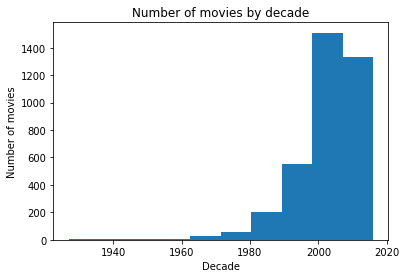

In [109]:
plt.hist(df['title_year'],bins=10)
plt.title('Number of movies by decade',fontsize=12)
plt.xlabel('Decade')
plt.ylabel('Number of movies')
plt.savefig("c:/thinkful/year_hist.png")
plt.show()

<font color=blue>
Most of the movies are 1980 or later, so let's create a categorical for the year instead of using the year as a calculated variable

In [110]:
df['post-1980'] = np.where(df['title_year']>=1980,1,0)
df = df.drop('title_year',1)

<font color=blue>
Now let's look at the content ratings.  Those are probably pretty valuable to determine the IMDb rating, but they're currently in a text format so we'll need to do something with that.

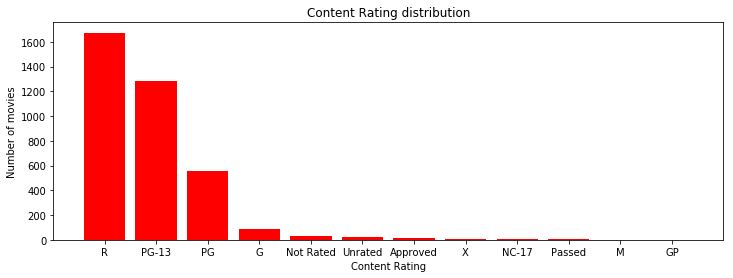

In [111]:
content_rating_count = df.content_rating.value_counts()
x = content_rating_count.index
plt.figure(figsize=(12,4))
plt.title('Content Rating distribution')
plt.rcParams.update({'font.size': 12})
plt.ylabel('Number of movies')
plt.xlabel('Content Rating')
plt.bar(x[0:],content_rating_count[0:],color='red')
plt.savefig("c:/thinkful/content_graph.png")
plt.show()

<font color=blue>
It looks like most are 'R','PG-13', and 'PG', so let's create some categoricals for those and drop the content_rating column

In [112]:
df['content_rating_R'] = np.where(df['content_rating'] == 'R', 1, 0)
df['content_rating_PG13'] = np.where(df['content_rating'] == 'PG-13', 1, 0)
df['content_rating_PG'] = np.where(df['content_rating'] == 'PG', 1, 0)
df = df.drop('content_rating',1)

<font color=blue>
Ok, let's take a look at the genres next and see what we should do there.

In [113]:
df['genres'][:10]

0                       Action|Adventure|Fantasy|Sci-Fi
1                              Action|Adventure|Fantasy
2                             Action|Adventure|Thriller
3                                       Action|Thriller
5                               Action|Adventure|Sci-Fi
6                              Action|Adventure|Romance
7     Adventure|Animation|Comedy|Family|Fantasy|Musi...
8                               Action|Adventure|Sci-Fi
9                      Adventure|Family|Fantasy|Mystery
10                              Action|Adventure|Sci-Fi
Name: genres, dtype: object

<font color=blue> Yikes!  Many of the movies are included in multiple genres.  We'll have to do 
some string manipulation here and figure out how to handle these.  Why don't we create categorical
variables of every genre, and then tag each movie with a '1' for each genre it's in. But first, let's check other variable correlation.
    

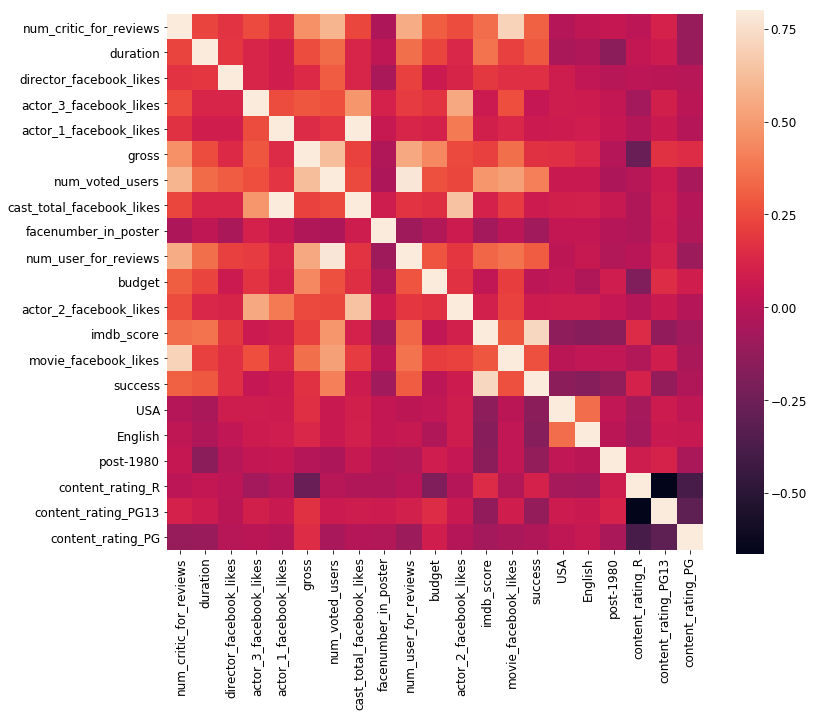

In [114]:
# Make the correlation matrix.
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.savefig("c:/thinkful/corr_mat.png")
plt.show()

<font color=blue>
We have a lot of correlated variables here, especially around the facebook stuff.  I'm going to remove the actor_2, actor_3 and cast_ variables, since those are probably not needed as actor_1 most likely grabs the lion's share.  Also, 'movie_facebook_likes' is highly correlated with the 'num_' variables, as well as gross (since it will obviously get a lot of votes if the gross is high).  I will keep 'gross' for now, since it's a financial and is somewhat related to budget, which we will probably need.  I willdiscard two of the num_ variables and also movie_facebook.

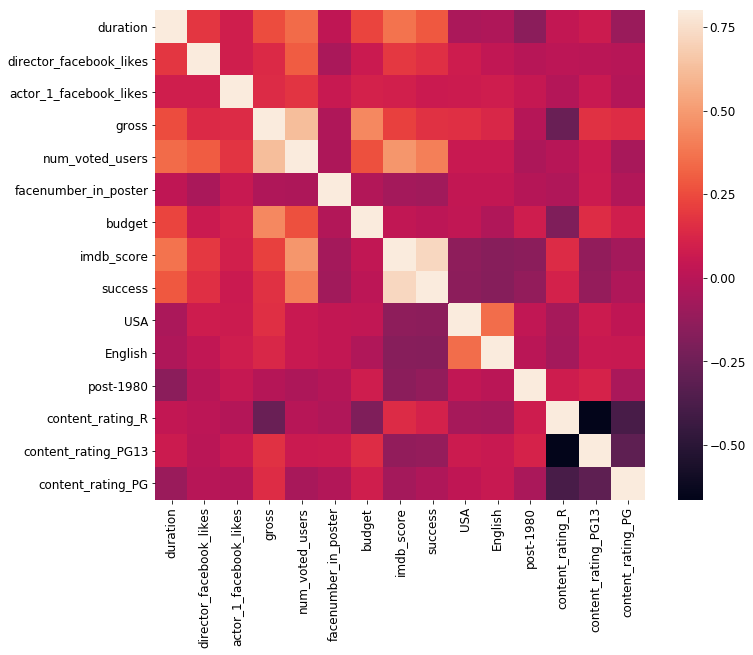

In [115]:
df = df.drop(['num_critic_for_reviews','num_user_for_reviews', 'movie_facebook_likes','cast_total_facebook_likes',
              'actor_2_facebook_likes','actor_3_facebook_likes'],1)

# Make the correlation matrix.
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

<font color=blue> Ok, that looks a little better.  There's still a few correlations but we can play around with those later.  Now let's add the genres.

In [116]:
df['genres'] = df['genres'].str.split("|")  # turns 'genres' string into list of categories for each row
genre_list_names = list(set([y for x in df['genres'] for y in x]))  #this extracts all unique values in list of lists
df['genres'][:5]

0    [Action, Adventure, Fantasy, Sci-Fi]
1            [Action, Adventure, Fantasy]
2           [Action, Adventure, Thriller]
3                      [Action, Thriller]
5             [Action, Adventure, Sci-Fi]
Name: genres, dtype: object

In [117]:
genre_list_names

['Comedy',
 'Fantasy',
 'Adventure',
 'Animation',
 'Film-Noir',
 'Thriller',
 'Drama',
 'Biography',
 'Family',
 'War',
 'Music',
 'Horror',
 'Sci-Fi',
 'History',
 'Western',
 'Mystery',
 'Documentary',
 'Musical',
 'Sport',
 'Crime',
 'Action',
 'Romance']

In [118]:
for col in genre_list_names:    #create the new columns and assign them to 0
    df[col] = df['genres'].apply(lambda x: 1 if col in x else 0)

df[genre_list_names].head(8) 



,Comedy,Fantasy,Adventure,Animation,Film-Noir,Thriller,Drama,Biography,Family,War,Music,Horror,Sci-Fi,History,Western,Mystery,Documentary,Musical,Sport,Crime,Action,Romance
0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
8,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


<font color=blue>
We also need to scale the variables, as we have some big numbers there.

In [119]:
#This creates a list of log values for the high number variables to normalize them for calculation

def var_log(var):
    log_name = var + '_log'
#    df[log_name] = np.where(df[var] > 0, np.log(df[var]),0)
    df[var+'_log'] = np.where(df[var] > 0, np.log(df[var]),0)
 
log_list = ['director_facebook_likes',
            'actor_1_facebook_likes',
            'num_voted_users',
            'budget',
            'gross',
            'duration']

for log in log_list:
    var_log(log)

c:\users\jb\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [120]:
df.head(2)

,duration,director_facebook_likes,actor_1_facebook_likes,gross,genres,num_voted_users,facenumber_in_poster,budget,imdb_score,success,USA,English,post-1980,content_rating_R,content_rating_PG13,content_rating_PG,Comedy,Fantasy,Adventure,Animation,Film-Noir,Thriller,Drama,Biography,Family,War,Music,Horror,Sci-Fi,History,Western,Mystery,Documentary,Musical,Sport,Crime,Action,Romance,director_facebook_likes_log,actor_1_facebook_likes_log,num_voted_users_log,budget_log,gross_log,duration_log
0,178.0,0.0,1000.0,760505847.0,"[Action, Adventure, Fantasy, Sci-Fi]",886204,0.0,237000000.0,7.9,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.00000,6.907755,13.694702,19.283571,20.449494,5.181784
1,169.0,563.0,40000.0,309404152.0,"[Action, Adventure, Fantasy]",471220,0.0,300000000.0,7.1,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6.33328,10.596635,13.063080,19.519293,19.550159,5.129899


In [124]:
#IMDb score--use logs

drop_col_imdb_scratch = ['gross','budget',
                  'genres',
                  'actor_1_facebook_likes',
                  'director_facebook_likes','num_voted_users',
                  'imdb_score','duration',
                   ]

df1 = df.drop(drop_col_imdb_scratch,1)

In [125]:
df1.head(2)

,facenumber_in_poster,success,USA,English,post-1980,content_rating_R,content_rating_PG13,content_rating_PG,Comedy,Fantasy,Adventure,Animation,Film-Noir,Thriller,Drama,Biography,Family,War,Music,Horror,Sci-Fi,History,Western,Mystery,Documentary,Musical,Sport,Crime,Action,Romance,director_facebook_likes_log,actor_1_facebook_likes_log,num_voted_users_log,budget_log,gross_log,duration_log
0,0.0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.00000,6.907755,13.694702,19.283571,20.449494,5.181784
1,0.0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6.33328,10.596635,13.063080,19.519293,19.550159,5.129899


<font color=blue>  Finally! We're done messing around with the data and have done some pretty good 
feature engineering.  Let's go ahead and run this sucker!  We'll use a test size of 10% (thus train size of 90%).

<font color=blue>  I'm going to set up a pipeline of the various methods that we've learned over the course and plot out their scores along with an AUC curve to determine how "true" our values are:

In [135]:
data = df1.drop('success',1)  # Success is our dependent variable
target = df1['success']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=4564)



 KNeighborsClassifier
model score: 0.784

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       239
           1       0.75      0.58      0.66       131

   micro avg       0.78      0.78      0.78       370
   macro avg       0.77      0.74      0.75       370
weighted avg       0.78      0.78      0.78       370



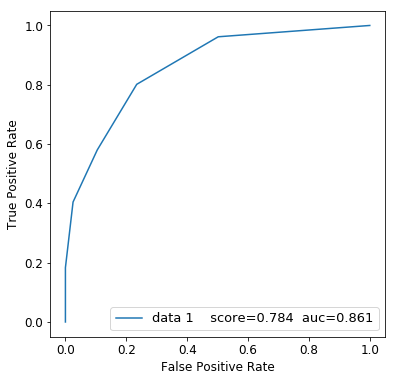



 DecisionTreeClassifier
model score: 0.773

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       239
           1       0.69      0.66      0.67       131

   micro avg       0.77      0.77      0.77       370
   macro avg       0.75      0.75      0.75       370
weighted avg       0.77      0.77      0.77       370



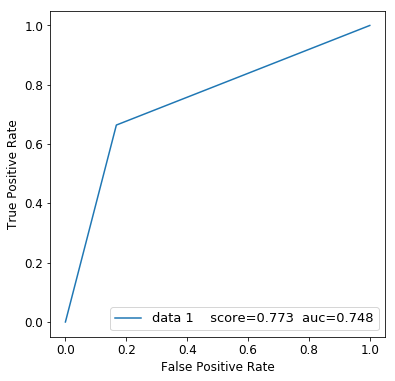



 RandomForestClassifier
model score: 0.819

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       239
           1       0.80      0.65      0.72       131

   micro avg       0.82      0.82      0.82       370
   macro avg       0.81      0.78      0.79       370
weighted avg       0.82      0.82      0.81       370



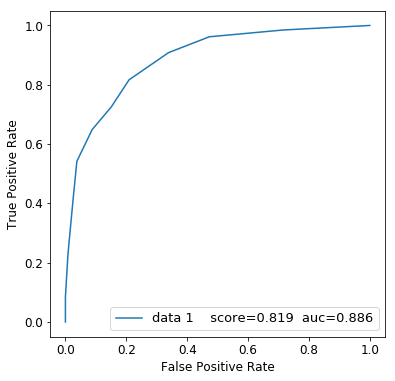



 LogisticRegression
model score: 0.830

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       239
           1       0.80      0.69      0.74       131

   micro avg       0.83      0.83      0.83       370
   macro avg       0.82      0.80      0.81       370
weighted avg       0.83      0.83      0.83       370



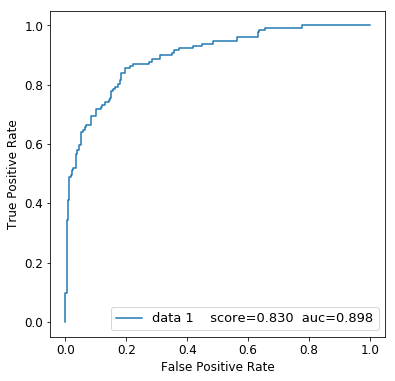



 LogisticRegression
model score: 0.827

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       239
           1       0.79      0.69      0.74       131

   micro avg       0.83      0.83      0.83       370
   macro avg       0.82      0.80      0.81       370
weighted avg       0.82      0.83      0.82       370



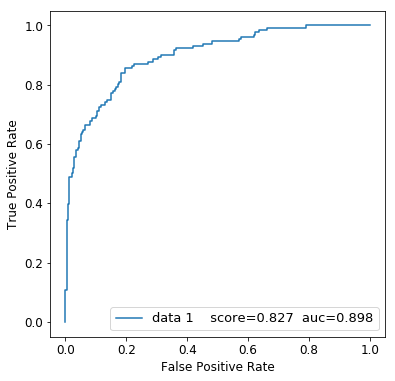



 GradientBoostingClassifier
model score: 0.843

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       239
           1       0.85      0.68      0.75       131

   micro avg       0.84      0.84      0.84       370
   macro avg       0.84      0.81      0.82       370
weighted avg       0.84      0.84      0.84       370



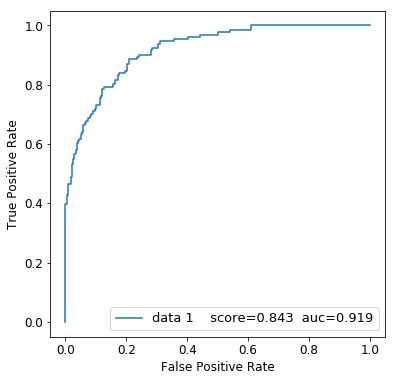

In [136]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(C=1e9,penalty='l2'), #Ridge
    LogisticRegression(C=19,penalty='l1'), #Lasso
    GradientBoostingClassifier() 
    ]  

i=0
for classifier in classifiers:
    i+=1
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    classifier_name = str(classifier)
    classifier_name = classifier_name.split("(")[0]
    print('\n\n',classifier_name)
    print("model score: %.3f\n" % pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
     
    y_pred_proba = pipe.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    fig = plt.figure(figsize=(6, 6))
    plt.plot(fpr,tpr,label="data 1    score=%.3f  " % pipe.score(X_test,y_test)+"auc="+str(round(auc,3)))

    plt.legend(loc=4,fontsize=13)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show() #for control
    
    filename = 'c:/Thinkful/model_'+str(i)+'.png'  
    fig.savefig(filename, dpi=fig.dpi)    #save the graphs so I can use them in the deck


<font color=blue>
So they all did fairly well (except KNN).  Gradient Boosting actually performed the best with a score of .843 and AUC of .92. Let's do a randomized search of parameters and see if we can get a little better score. 

In [32]:
# Number of trees in random forest
gb_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]  # Maximum number of levels in tree 
max_features = ['auto', 'sqrt']
gb_max_depth = [int(x) for x in np.linspace(2,12, num = 6)]
gb_max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
loss = ['deviance','exponential']

gb_random_grid = {'n_estimators': gb_n_estimators,
               'max_features': max_features,
               'max_depth': gb_max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'loss': loss}
pprint(rf_random_grid)
{'bootstrap': [True, False],
 'max_depth': [5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 300, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

pprint(gb_random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 6, 11, 16, 21, 26, 30, 35, 40, 45, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}
{'loss': ['deviance', 'exponential'],
 'max_depth': [2, 4, 6, 8, 10, 12, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [36]:
# Use the random grid to search for best hyperparameters

gb = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = gb_random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)
print(gb_random.best_params_)

clf = GradientBoostingClassifier(**gb_random.best_params_)
clf.fit(X_train,y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
score = clf.score(X_test,y_test)
print('\nscore = {}, auc = {}'.format(round(score,3),round(auc,3)))

cv_score = cross_val_score(clf, data, target, cv=10)
print('Mean cv score = ',round(cv_score.mean(),3),'\n',cv_score)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'exponential'}

score = 0.846, auc = 0.924
Mean cv score =  0.797 
 [0.77567568 0.85135135 0.85135135 0.83243243 0.80540541 0.85945946
 0.77027027 0.71621622 0.76358696 0.74456522]


In [38]:
clf = GradientBoostingClassifier(**gb_random.best_params_)
clf.fit(X_train,y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
score = gb_random.score(X_test,y_test)
print('\nscore = {}, auc = {}'.format(round(score,3),round(auc,3)))
print(gb_random.best_params_)

cv_score = cross_val_score(clf, data, target, cv=10)
print('\nMean cv score = ',round(cv_score.mean(),3),'\n',cv_score)


score = 0.854, auc = 0.922
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'exponential'}
Mean cv score =  0.802 
 [0.78378378 0.84864865 0.85675676 0.84054054 0.81351351 0.84864865
 0.78378378 0.73513514 0.76358696 0.75      ]


In [137]:
clf = GradientBoostingClassifier(**gb_random.best_params_)
clf.fit(X_train,y_train)
y_pred_proba = clf.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
score = gb_random.score(X_test,y_test)
print('\nscore = {}, auc = {}'.format(round(score,3),round(auc,3)))
print(gb_random.best_params_)

cv_score = cross_val_score(clf, data, target, cv=10)
print('\nMean cv score = ',round(cv_score.mean(),3),'\n',cv_score)


score = 0.854, auc = 0.927
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'exponential'}

Mean cv score =  0.805 
 [0.78918919 0.85945946 0.84324324 0.84054054 0.82702703 0.85675676
 0.78918919 0.73243243 0.76086957 0.75543478]


In [138]:
gb_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'exponential'}

<font color=blue>  So we got a little boost from the parameters.  The cross_val score is in the ballpark--further research would be to investigate the data set more to understand the lower scores.<br>
Let's look at our feature list.

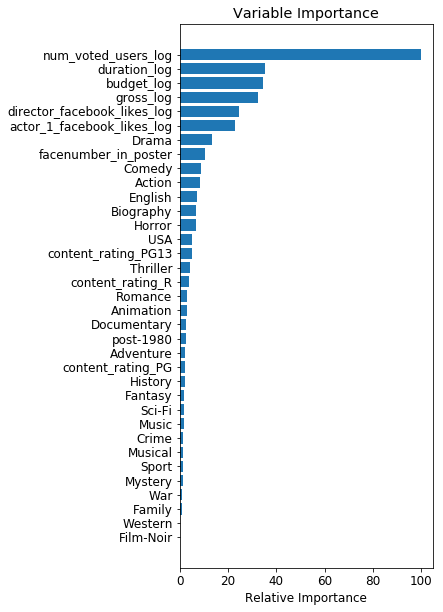

In [139]:
feature_importance = clf.feature_importances_
#feature_importance.sort(reverse=True)

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

filename = 'c:/Thinkful/features.png'  
fig.savefig(filename, dpi=fig.dpi)    #save the graphs so I can use them in the deck

<font color=blue>  So num_voted_users was the most important feature for determination (not surprising, since a lot of people voting probably means it's a good move).  Interestingly (or maybe not), only a few of the genres added some "oomph" to the data.  With more time we can delete some of these to determine if the score stays in the ballpark.
    
In general, Gradient Boosting did a fairly good job of classifying a "good" movie--20% better than just doing a random guess.  There's a lot of other things that we could explore in this data set, but it's easy to get bogged down in details (as I found out too often).  This was a fun project, and really brought about a lot of things to consider when doing a deep dive on a a dataset.